In [1]:
# import libraries
import yfinance as yf
import pandas as pd
import graphviz
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import seaborn as sns 
from sklearn import tree
import math
%matplotlib inline

# Declaring Functions

In [2]:
# read in the data
def read_in_data(stock, start_date, end_date):
    return yf.download(stock, start=start_date, end=end_date)

In [3]:
def data_preparation(master_df):  
    # make a copy of the dataframe
    df = master_df.copy() 
    # convert date index into a column - so code below works
    df.reset_index(level=0, inplace=True)
    # ordering by date - in case date column is in the wrong order
    df['date_time'] =  pd.to_datetime(df['Date'], format='%Y-%m-%d')
    df = df.sort_values('date_time', axis=0)
    
    # Feature selection
    # create the MACD line, signal line and MACD signal line
    day12 = df['Close'].ewm(span=12).mean()  
    day26 = df['Close'].ewm(span=26).mean()
    macd = [] 
    counter=0  
    while counter < (len(day12)):
        macd.append(day12.iloc[counter] - day26.iloc[counter]) 
        counter += 1
    df['macd'] = macd
    df['signal'] = df['macd'].ewm(span=9).mean() 
    df['temp'] = (df['macd'] - df['signal'])
    df['macd_signal'] = 1
    df.loc[df['temp']<0, ['macd_signal']] = 0
    df = df.drop(['macd', 'signal', 'temp'], axis=1)

    # Simple moving average
    sma_time = 5
    df['SMA'] = df['Close'].rolling(sma_time, win_type=None).mean()

    # Momentum
    momentum_time = 5
    df['momentum_5_day'] = df['Close'] - df['Close'].shift(momentum_time)
    momentum_time_2 = 1
    df['momentum_1_day'] = df['Close'] - df['Close'].shift(momentum_time_2)

    # Exponential moving average
    ema_time = 7
    df['EMA'] = df['Close'].ewm(span=ema_time).mean() 

    # Open minus Close t-1
    df['open_minus_pre_close'] = df['Open'] - df['Close'].shift(1)

    # One day change in volume
    df['volume_1_day_change'] = df['Volume'] - df['Volume'].shift(1)

    # RSI
    df['up'] = 0
    df['down'] = 0
    df.loc[(df['Close'] - df['Close'].shift(1)) > 0, ['up']] = (df['Close'] - df['Close'].shift(1))
    df.loc[(df['Close'] - df['Close'].shift(1)) < 0, ['down']] = (df['Close'] - df['Close'].shift(1))

    df['avg_gain'] = 0
    df['avg_loss'] = 0

    df['avg_gain'] = (df['up'] + df['up'].shift(1) + df['up'].shift(2) + df['up'].shift(3) + df['up'].shift(4) + df['up'].shift(5) + df['up'].shift(6) + df['up'].shift(7) + df['up'].shift(8) + df['up'].shift(9) + df['up'].shift(10) + df['up'].shift(11) + df['up'].shift(12) + df['up'].shift(13))/14.0
    df['avg_loss'] =abs(df['down'] + df['down'].shift(1) + df['down'].shift(2) + df['down'].shift(3) + df['down'].shift(4) + df['down'].shift(5) + df['down'].shift(6) + df['down'].shift(7) + df['down'].shift(8) + df['down'].shift(9) + df['down'].shift(10) + df['down'].shift(11) + df['down'].shift(12) + df['down'].shift(13))/14.0

    df['RSvalue'] = df['avg_gain']/df['avg_loss']
    df['RSI'] = 100 - (100/(1+df['RSvalue']))
    df = df.drop(['up', 'down', 'avg_gain', 'avg_loss', 'RSvalue'], axis=1)

    # Close price lags
    # function to create n lags for specificed column
    def add_lags(df, column, lags):
        cols = []
        for lag in range(1, lags+1):
            col = '%s_lag_%d' % (column, lag)
            df[col] = df[column].shift(lag)
            cols.append(col)
        return df

    # create the return column
    df['return'] = np.log(df['Close'] / df['Close'].shift(1))
    # next create the lagged data
    df = add_lags(df, 'return', 5)

    # Because when we run the model for real, we will not know the EOD metrics
    # we need t-1 lag for each of them
    df = add_lags(df, 'macd_signal', 1)
    df = add_lags(df, 'SMA', 1)
    df = add_lags(df, 'momentum_5_day', 1)
    df = add_lags(df, 'momentum_1_day', 1)
    df = add_lags(df, 'EMA', 1)
    df = add_lags(df, 'open_minus_pre_close', 1)
    df = add_lags(df, 'volume_1_day_change', 1)
    df = add_lags(df, 'RSI', 1)
    

    # the target is the sign of the return
    df['return_sign'] = np.sign(df['return'].values)

    # Delete columns not needed
    # delete return column
    df = df.drop(['return', 'Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close', 'macd_signal', 'SMA', 'momentum_1_day', 'momentum_5_day', 'EMA', 'open_minus_pre_close', 'volume_1_day_change', 'RSI', 'Date'], axis=1)
    # delete rows with nan in them
    df = df.dropna(axis=0)

    # drop all rows with zero in return_sign column
    df = df[df.return_sign != 0]
    # the question says we can class the target value of '1' as '0' and '-1' and '1'
    df['return_sign'] = df['return_sign'].replace(1, 0)
    df['return_sign'] = df['return_sign'].replace(-1, 1)
    
    # percentage of positive and negative returns
    class_value, counts = np.unique(df['return_sign'], return_counts=True)
    print('The percentage of class value: %.0f is %.2f%%' % (class_value[0], (counts[0] / len(df)) * 100.0))
    print('And the percentage of class value: %.0f is %.2f%%' % (class_value[1], (counts[1] / len(df)) * 100.0))
    print('\n')
    
    # split the data and the target data
    target = df['return_sign']
    data = df.drop(['return_sign'], axis=1)
    
    # split test and training dataframe
    x_train, x_test, y_train, y_test = train_test_split(data, target, test_size=0.20, random_state=42, shuffle=False)
    # now drop the data_time column
    date_time_train = x_train['date_time']
    date_time_test = x_test['date_time']
    x_train = x_train.drop(['date_time'], axis=1)
    x_test = x_test.drop(['date_time'], axis=1)
    # data columns names
    data_col_names = x_train.columns.values
    print('List of features used: ', data_col_names)
    print('\n')
    
    class_value, counts = np.unique(y_train, return_counts=True)
    print('The percentage of class value: %.0f is %.2f%% for the training dataset' % (class_value[0], (counts[0] / len(y_train)) * 100.0))
    print('And the percentage of class value: %.0f is %.2f%% for the training dataset' % (class_value[1], (counts[1] / len(y_train)) * 100.0))
    print('\n')
    
    class_value, counts = np.unique(y_test, return_counts=True)
    print('The percentage of class value: %.0f is %.2f%% for the test dataset' % (class_value[0], (counts[0] / len(y_test)) * 100.0))
    print('And the percentage of class value: %.0f is %.2f%% for the test dataset' % (class_value[1], (counts[1] / len(y_test)) * 100.0))
    
    return x_train, y_train, x_test, y_test, date_time_train, date_time_test, target, data_col_names

In [4]:
# decision tree classifier model
def run_decision_tree_classifier(x_train, y_train, x_test, criterion, max_depth, min_samples_leaf, min_samples_split):
    model = DecisionTreeClassifier(criterion = criterion,
                             max_depth = max_depth, 
                             min_samples_leaf = min_samples_leaf, 
                             min_samples_split = min_samples_split,
                             random_state = 0)

    model.fit(x_train, y_train)
    predicted_array = model.predict(x_test) 
    predicted_array_train = model.predict(x_train) 
    predicted_proba_train = model.predict_proba(x_train)
    predicted_proba_test = model.predict_proba(x_test)
    
    return model, predicted_array, predicted_array_train, predicted_proba_train, predicted_proba_test

In [5]:
# decision tree regressor model
def run_decision_tree_regressor(x_train, y_train, x_test, criterion, max_depth, min_samples_leaf, min_samples_split):
    model = DecisionTreeRegressor(criterion = criterion,
                             max_depth = max_depth, 
                             min_samples_leaf = min_samples_leaf, 
                             min_samples_split = min_samples_split,
                             random_state = 0)

    model.fit(x_train, y_train)
    predicted_array = model.predict(x_test) 
    
    return model, predicted_array

In [6]:
# tuning hyper-parameters in the decision tree classifier model
def run_grid_search(x_train, y_train, x_test, model, parameters, scoring, cv):
    grid_search = GridSearchCV(model, parameters, scoring=scoring, cv=cv)
    grid_search.fit(x_train, y_train)
    grid_search_model = grid_search.best_estimator_
    grid_search_model_params = grid_search_model.get_params()
    predicted_array = grid_search_model.predict(x_test) 
    predicted_array_train = grid_search_model.predict(x_train) 
    predicted_proba_train = grid_search_model.predict_proba(x_train)
    predicted_proba_test = grid_search_model.predict_proba(x_test)
    grid_search_results = grid_search.cv_results_ 

    return grid_search_model, grid_search_model_params, predicted_array, predicted_array_train, predicted_proba_train, predicted_proba_test, grid_search_results

In [7]:
# AdaBoost
def run_adaboost(x_train, y_train, x_test, n_estimators, learning_rate, base_estimator):
    model = AdaBoostClassifier(n_estimators=n_estimators, learning_rate=learning_rate, base_estimator=base_estimator, random_state=0)
    # train the model
    model.fit(x_train, y_train)
    # run the test set through the model
    predicted_array = model.predict(x_test)
    predicted_array_train = model.predict(x_train)
    predicted_proba_train = model.predict_proba(x_train)
    predicted_proba_test = model.predict_proba(x_test)
    
    return model, predicted_array, predicted_array_train, predicted_proba_train, predicted_proba_test

In [8]:
# confusion matrix
def plot_confusion_matrix(y_true, predicted_array, class_names, title):
    cm = confusion_matrix(y_true, predicted_array)
    print(cm)
    dataframe = pd.DataFrame(cm, index=class_names, columns=class_names)
    sns.heatmap(dataframe, annot=True, cmap='Blues', fmt='g')
    plt.title(title)
    plt.ylabel('True Class'), plt.xlabel('Predicted Class')
    plt.show()
    return cm

In [9]:
# Accuracy, Sensitivity/recall, Precision and F1 score
def key_metrics(y_true, predicted_array):
    # Accuarcy
    dt_1_accuracy = (accuracy_score(y_true, predicted_array, normalize=True)*100.0)
    print('Accuracy: %.2f%%' % dt_1_accuracy)
    # Sensitivity/recall
    df_1_recall = (recall_score(y_true, predicted_array, average='weighted')*100.0)
    print('Recall: %.2f%%' % df_1_recall)
    # Precision
    df_1_precision = (precision_score(y_true, predicted_array, average='weighted')*100.0)
    print('Precision: %.2f%%' % df_1_precision)
    # F-score
    df_1_f1 = (f1_score(y_true, predicted_array, average='weighted')*100.0)
    print('F-score: %.2f%%' % df_1_f1)

In [10]:
# feature importance
def plot_feature_importance(true_value, predicted_value, importance, features, title):
    
    true_and_pred_data = {'true_value': true_value, 'predicted_value': predicted_value}
    predicted_true_testset = pd.DataFrame(data = true_and_pred_data, columns = ['true_value', 'predicted_value'])
    indices = np.argsort(importance)

    plt.figure(figsize=(15, 7))
    plt.title(title)
    plt.barh(range(len(indices)), importance[indices], color='b', align='center')
    plt.yticks(range(len(indices)), features[indices])
    plt.xlabel('Relative Importance')
    plt.show()

In [11]:
# decision boundaries 
def decision_boundary_four_features(x_train, y_train, feature_1, feature_2, feature_3, feature_4, model, plot_title, class_names):
    # Parameters
    n_classes = 2
    plot_colors = "ryb"
    plot_step = 0.01
    marker_colours = 'rb'
    contour_colours = plt.cm.RdBu
    
    plt.figure(figsize=(7, 7))

    for pairidx, pair in enumerate([[feature_1, feature_2], [feature_1, feature_3], [feature_1, feature_4],
                                    [feature_2, feature_3], [feature_2, feature_4], [feature_3, feature_4]]):

        # We only take the two corresponding features
        X = x_train[pair]
        y = y_train
        # normalise the two feature columns, so they both go from 0 to 1 - so the code does not hang
        X =(X-X.min())/(X.max()-X.min())

        # Train
        clf1 = model.fit(X, y)

        plt.subplot(2, 3, pairidx + 1)

        x_min, x_max = X[pair[0]].min() - 0.1, X[pair[0]].max() + 0.1
        y_min, y_max = X[pair[1]].min() - 0.1, X[pair[1]].max() + 0.1

        xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                             np.arange(y_min, y_max, plot_step))

        plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

        Z = clf1.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        cs = plt.contourf(xx, yy, Z, cmap=contour_colours)

        plt.xlabel(pair[0])
        plt.ylabel(pair[1])

        # Plot the training points
        for i, color in zip(range(n_classes), marker_colours):
            idx = np.where(y == i)
            plt.scatter(X[pair[0]].iloc[idx], X[pair[1]].iloc[idx], c=color, label=class_names[i],
                        cmap=contour_colours, edgecolor='black', s=15)

    plt.suptitle(plot_title, size = 'medium')
    plt.legend(loc='lower right', borderpad=0, handletextpad=0, bbox_to_anchor=(1.5, 1))
    plt.axis("tight")

In [12]:
# transition probabilities
def plotting_transition_probabilty(predicted_proba, true_value, date_time, suptitle):
    # first column probabilty it has been assigned to class '0', and second column probability it is assigned to class '1'
    zero_prob = predicted_proba[:, 0]
    one_prob = predicted_proba[:, 1]
    # convert these into a dataframe, and add the true value of the data
    result_data = {'zero_prob': zero_prob, 'one_prob': one_prob, 'true_value': true_value, 'date_time': date_time}
    result_df = pd.DataFrame(data=result_data, columns=['zero_prob', 'one_prob', 'true_value', 'date_time']).reset_index(drop=True)

    # now separate the results dataframe into ture value = 1 and 0
    result_df_0 = result_df.loc[result_df['true_value'] < 1]
    result_df_1 = result_df.loc[result_df['true_value'] > 0]

    # plot both graphs
    # zero figure
    plt.figure()
    plt.plot(result_df_0['date_time'], result_df_0['zero_prob'], 'o', marker = 'o', color = 'green', label="Correctly predicted")
    plt.plot(result_df_1['date_time'], result_df_1['zero_prob'], 'o', marker = 'o', color = 'red', label="Incorrectly predicted")
    plt.xlabel('Time')
    plt.ylabel('Prodability')
    plt.ylim(0,1)
    plt.suptitle(suptitle)
    plt.title("The probability of a data point being assigned to the '0' class")
    plt.legend(loc="upper right", bbox_to_anchor=(1.5, 1))
    plt.gcf().autofmt_xdate()
    plt.show()

    # one figure
    plt.figure()
    plt.plot(result_df_1['date_time'], result_df_1['one_prob'], 'o', marker = 'o', color = 'green', label="Correctly predicted")
    plt.plot(result_df_0['date_time'], result_df_0['one_prob'], 'o', marker = 'o', color = 'red', label="Incorrectly predicted")
    plt.xlabel('Time')
    plt.ylabel('Prodability')
    plt.ylim(0,1)
    plt.suptitle(suptitle)
    plt.title("The probability of a data point being assigned to the '1' class")
    plt.legend(loc="upper right", bbox_to_anchor=(1.5, 1))
    plt.gcf().autofmt_xdate()
    plt.show()


# Reading in the data

In [13]:
print('Read in Macys stock')
M_master_df = read_in_data('M', '2015-01-01', '2020-01-01')
M_master_df.head()

Read in Macys stock
[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,66.330002,66.959999,64.940002,65.690002,49.107407,4503800
2015-01-05,64.730003,65.440002,64.669998,65.129997,48.688759,5004600
2015-01-06,65.410004,65.750000,64.059998,64.889999,48.509350,4282900
2015-01-07,67.559998,67.830002,66.269997,67.550003,50.497864,8131800
2015-01-08,68.260002,68.300003,67.400002,67.809998,50.692226,4995900


In [14]:
print('Read in Electronic Arts stock')
EA_master_df = read_in_data('EA', '2015-01-01', '2020-01-01')
EA_master_df.head()

Read in Electronic Arts stock
[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,47.189999,47.669998,46.580002,46.869999,46.807629,1959800
2015-01-05,46.959999,47.340000,46.520000,46.570000,46.508026,2727600
2015-01-06,46.869999,47.330002,45.419998,45.959999,45.898838,4418900
2015-01-07,46.270000,47.029999,46.099998,46.810001,46.747711,4849400
2015-01-08,47.009998,48.250000,47.009998,48.130001,48.065952,3877000


# Data preparation and bias checks

In [15]:
print('data preparation: Macys stock')
M_x_train, M_y_train, M_x_test, M_y_test, M_date_time_train, M_date_time_test, M_target, M_data_col_names = data_preparation(M_master_df)

data preparation: Macys stock
The percentage of class value: 0 is 50.69%
And the percentage of class value: 1 is 49.31%


List of features used:  ['return_lag_1' 'return_lag_2' 'return_lag_3' 'return_lag_4'
 'return_lag_5' 'macd_signal_lag_1' 'SMA_lag_1' 'momentum_5_day_lag_1'
 'momentum_1_day_lag_1' 'EMA_lag_1' 'open_minus_pre_close_lag_1'
 'volume_1_day_change_lag_1' 'RSI_lag_1']


The percentage of class value: 0 is 50.91% for the training dataset
And the percentage of class value: 1 is 49.09% for the training dataset


The percentage of class value: 0 is 49.80% for the test dataset
And the percentage of class value: 1 is 50.20% for the test dataset


In [16]:
print('data preparation: Electronic Arts stock')
EA_x_train, EA_y_train, EA_x_test, EA_y_test, EA_date_time_train, EA_date_time_test, EA_target, EA_data_col_names = data_preparation(EA_master_df)

data preparation: Electronic Arts stock
The percentage of class value: 0 is 52.14%
And the percentage of class value: 1 is 47.86%


List of features used:  ['return_lag_1' 'return_lag_2' 'return_lag_3' 'return_lag_4'
 'return_lag_5' 'macd_signal_lag_1' 'SMA_lag_1' 'momentum_5_day_lag_1'
 'momentum_1_day_lag_1' 'EMA_lag_1' 'open_minus_pre_close_lag_1'
 'volume_1_day_change_lag_1' 'RSI_lag_1']


The percentage of class value: 0 is 52.47% for the training dataset
And the percentage of class value: 1 is 47.53% for the training dataset


The percentage of class value: 0 is 50.81% for the test dataset
And the percentage of class value: 1 is 49.19% for the test dataset


# Decision tree classification

In [17]:
# model hyper-parameters
criterion = str('gini')
max_depth = 10
min_samples_leaf = 5
min_samples_split = 10

### Decision tree for Macys

Decision tree for Macys


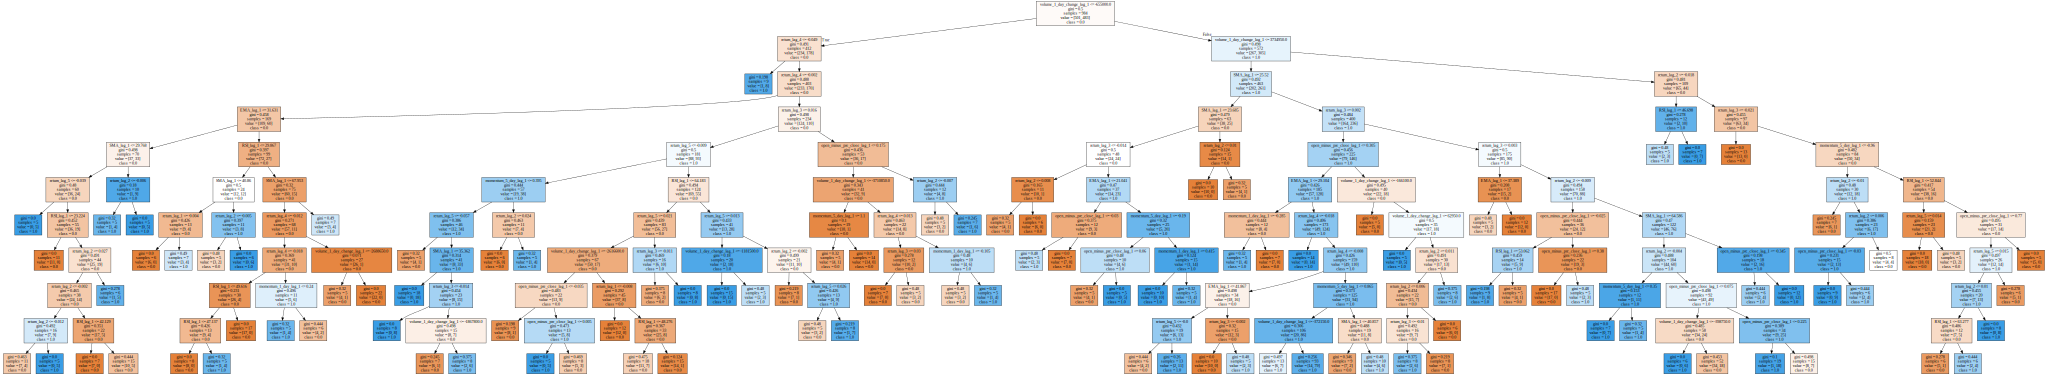

In [18]:
print('Decision tree for Macys')
M_dtc, M_dt_predicted_array, M_dt_predicted_array_train, M_dt_predicted_proba_train, M_dt_predicted_proba_test = run_decision_tree_classifier(M_x_train, M_y_train, M_x_test, criterion, max_depth, min_samples_leaf, min_samples_split)

M_fn = M_data_col_names
M_cn = np.unique(M_target.apply(str))

# plot up the decision tree
# DOT data
dot_data = tree.export_graphviz(M_dtc, 
                                out_file=None, 
                                feature_names=M_fn,  
                                class_names=M_cn,
                                filled=True)
# Draw graph
graph = graphviz.Source(dot_data, format="png") 
graph

Metrics

[[86 37]
 [77 47]]


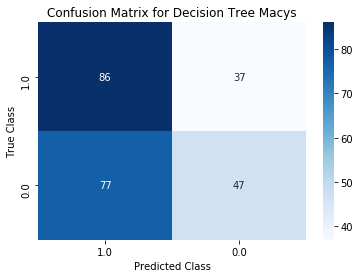

In [19]:
M_class_names = M_y_test.unique()
M_dt_cm = plot_confusion_matrix(M_y_test, M_dt_predicted_array, M_class_names, 'Confusion Matrix for Decision Tree Macys')

In [20]:
key_metrics(M_y_test, M_dt_predicted_array)

Accuracy: 53.85%
Recall: 53.85%
Precision: 54.36%
F-score: 52.64%


Feature importance

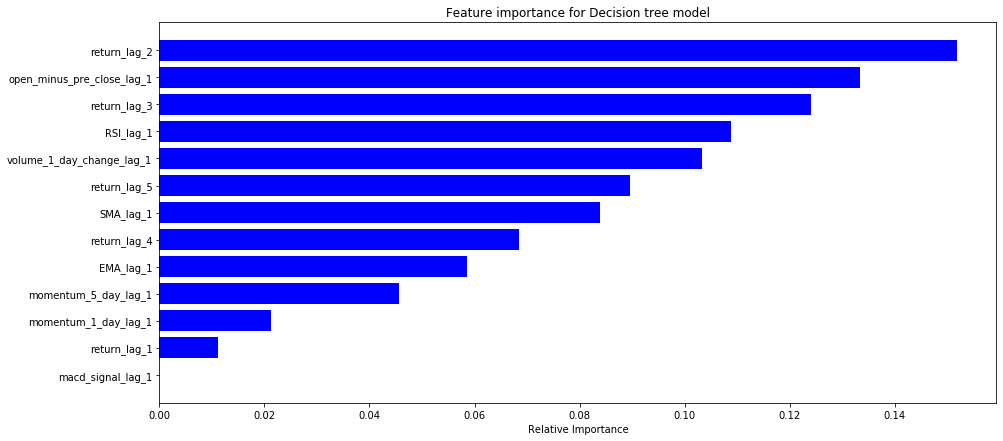

In [21]:
M_features = M_x_train.columns
M_importance_dt = M_dtc.feature_importances_
plot_feature_importance(M_y_test, M_dt_predicted_array, M_importance_dt, M_features, 'Feature importance for Decision tree model')

### Decision tree model for Electronic Arts

Decision tree model for Electronic Arts


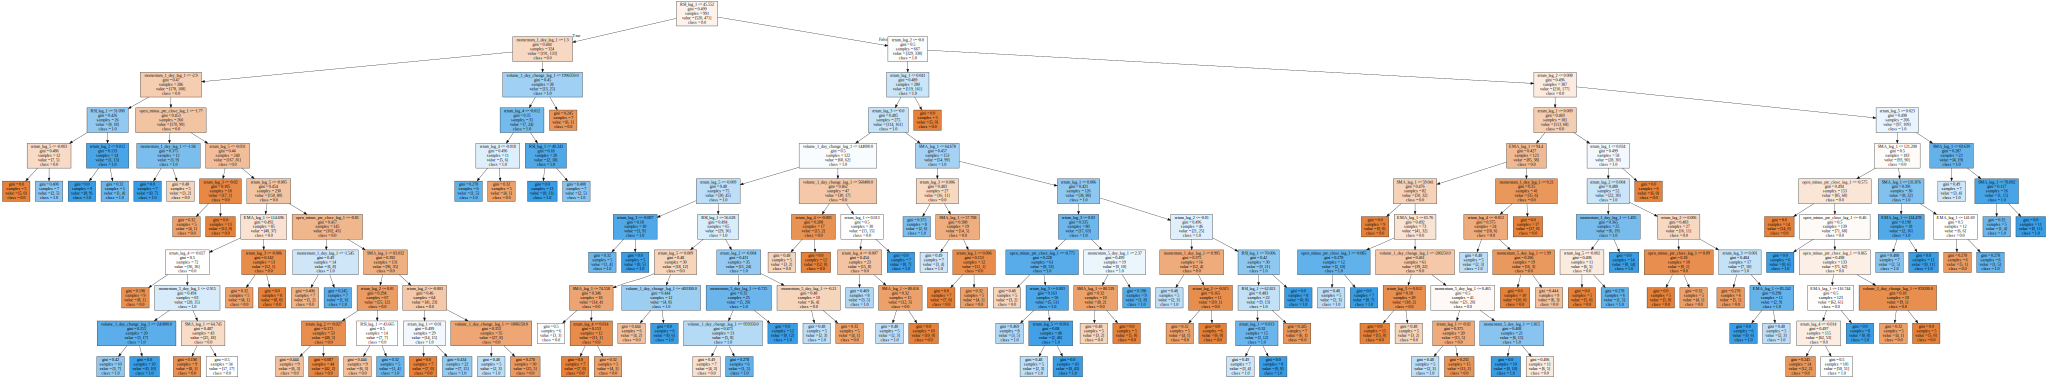

In [22]:
print('Decision tree model for Electronic Arts')
EA_dtc, EA_dt_predicted_array, EA_dt_predicted_array_train, EA_dt_predicted_proba_train, EA_dt_predicted_proba_test = run_decision_tree_classifier(EA_x_train, EA_y_train, EA_x_test, criterion, max_depth, min_samples_leaf, min_samples_split)

EA_fn = EA_data_col_names
EA_cn = np.unique(EA_target.apply(str))

# plot up the decision tree
# DOT data
dot_data = tree.export_graphviz(EA_dtc, 
                                out_file=None, 
                                feature_names=EA_fn,  
                                class_names=EA_cn,
                                filled=True)
# Draw graph
graph = graphviz.Source(dot_data, format="png") 
graph

Metrics

[[61 65]
 [55 67]]


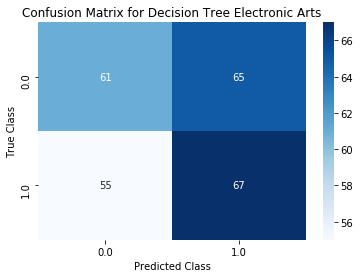

In [23]:
EA_class_names = EA_y_test.unique()
EA_df_cm = plot_confusion_matrix(EA_y_test, EA_dt_predicted_array, EA_class_names, 'Confusion Matrix for Decision Tree Electronic Arts')

In [24]:
key_metrics(EA_y_test, EA_dt_predicted_array)

Accuracy: 51.61%
Recall: 51.61%
Precision: 51.69%
F-score: 51.57%


Feature importance

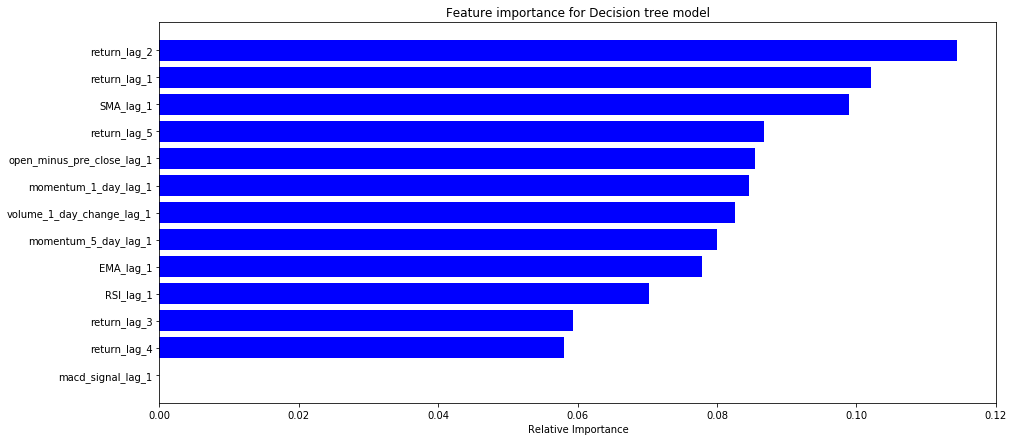

In [25]:
EA_features = EA_x_train.columns
EA_importance_dt = EA_dtc.feature_importances_
plot_feature_importance(EA_y_test, EA_dt_predicted_array, EA_importance_dt, EA_features, 'Feature importance for Decision tree model')

# Decison tree regressor

In [26]:
criterion = 'mse'
max_depth = 10
min_samples_leaf = 5
min_samples_split = 2

### Decision tree regressor for Macys

Decision tree regressor for Macys


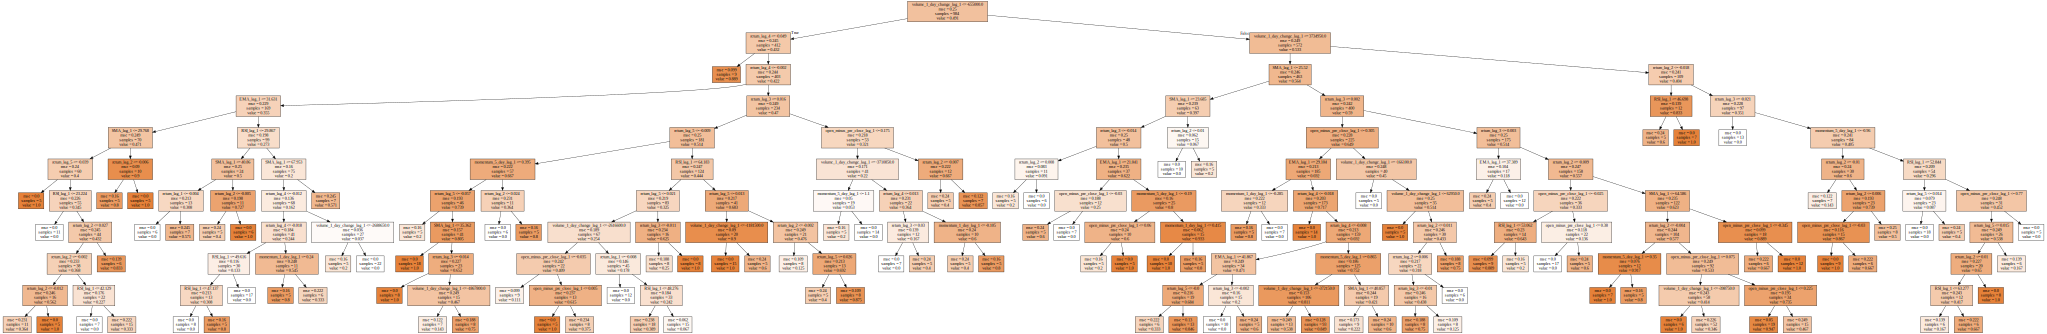

In [27]:
print('Decision tree regressor for Macys')
M_dtr, M_dtr_predicted_array = run_decision_tree_regressor(M_x_train, M_y_train, M_x_test, criterion, max_depth, min_samples_leaf, min_samples_split)
# plot decision tree
# DOT data
dot_data = tree.export_graphviz(M_dtr, 
                                out_file=None, 
                                feature_names=M_fn,  
                                class_names=M_cn,
                                filled=True)
# Draw graph
graph = graphviz.Source(dot_data, format="png") 
graph

For a regressor, normally the best statistic to use is R^2

In [28]:
# calcuate the R^2 of the model on the training set - for regression
M_r_2_train = M_dtr.score(M_x_train, M_y_train)
M_r_2_test = M_dtr.score(M_x_test, M_y_test)
print('R^2 of train: %.3f R^2 of test: %.3f' % (M_r_2_train, M_r_2_test))

R^2 of train: 0.573 R^2 of test: -0.507


But a better way to compare the regression decison tree and classification random forest is to use the dtr_predicted_array similar to predict_proba and assign the data point to either class 0 or 1, and then plot a confusion matrix

[[85 38]
 [76 48]]


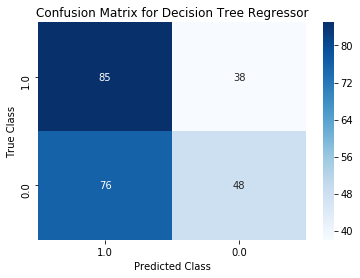

In [29]:
M_reg_data = {'predicted_value': M_dtr_predicted_array}
M_reg_df = pd.DataFrame(data=M_reg_data, columns=['predicted_value'])

# create a new column
M_reg_df['predicted_class'] = 0
M_reg_df.loc[M_reg_df['predicted_value'] >= 0.5, ['predicted_class']] = int(1)

# next convert reg_df['predicted_class'] into an numpy array and create the confusion matrix
M_predicted_class_dtr = M_reg_df['predicted_class'].to_numpy()

# plot confusion matrix
M_reg_cm = plot_confusion_matrix(M_y_test, M_predicted_class_dtr, M_class_names, 'Confusion Matrix for Decision Tree Regressor')

In [30]:
key_metrics(M_y_test, M_predicted_class_dtr)

Accuracy: 53.85%
Recall: 53.85%
Precision: 54.31%
F-score: 52.76%


### Decision tree regressor for Electronic Arts

Decision tree regressor for Electronic Arts


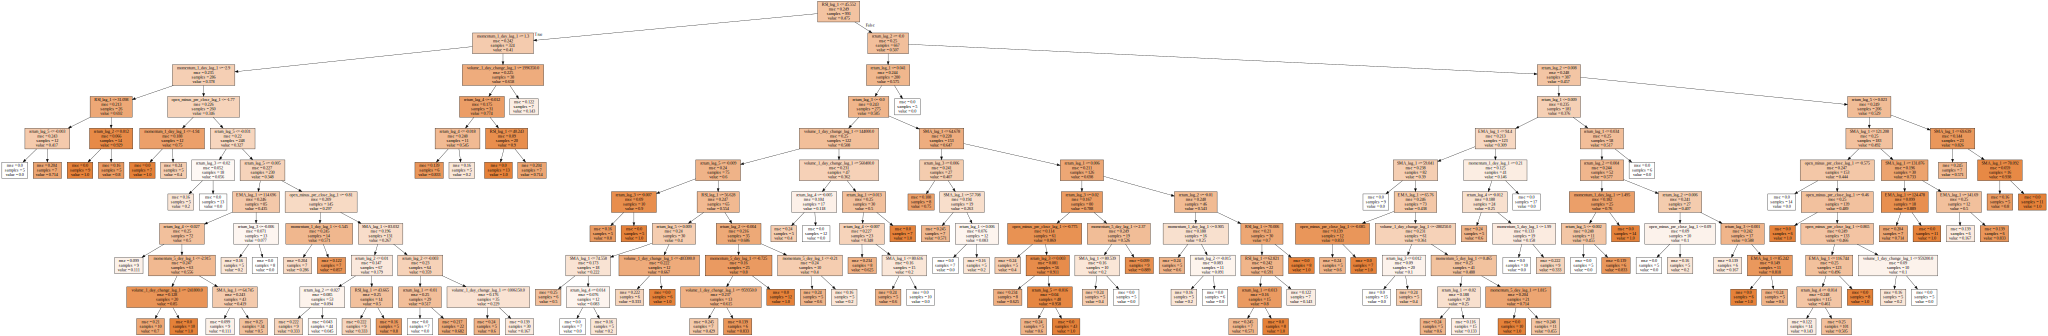

In [31]:
print('Decision tree regressor for Electronic Arts')
EA_dtr, EA_dtr_predicted_array = run_decision_tree_regressor(EA_x_train, EA_y_train, EA_x_test, criterion, max_depth, min_samples_leaf, min_samples_split)
# plot decision tree
# DOT data
dot_data = tree.export_graphviz(EA_dtr, 
                                out_file=None, 
                                feature_names=EA_fn,  
                                class_names=EA_cn,
                                filled=True)
# Draw graph
graph = graphviz.Source(dot_data, format="png") 
graph

In [32]:
# calcuate the R^2 of the model on the training set - for regression
EA_r_2_train = EA_dtr.score(EA_x_train, EA_y_train)
EA_r_2_test = EA_dtr.score(EA_x_test, EA_y_test)
print('R^2 of train: %.3f R^2 of test: %.3f' % (EA_r_2_train, EA_r_2_test))

R^2 of train: 0.527 R^2 of test: -0.522


[[57 69]
 [50 72]]


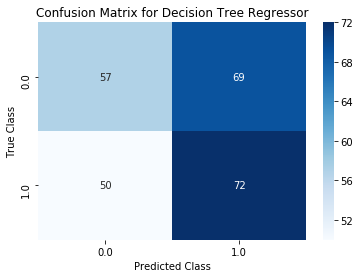

In [33]:
EA_reg_data = {'predicted_value': EA_dtr_predicted_array}
EA_reg_df = pd.DataFrame(data=EA_reg_data, columns=['predicted_value'])

# create a new column
EA_reg_df['predicted_class'] = 0
EA_reg_df.loc[EA_reg_df['predicted_value'] >= 0.5, ['predicted_class']] = int(1)

# next convert reg_df['predicted_class'] into an numpy array and create the confusion matrix
EA_predicted_class_dtr = EA_reg_df['predicted_class'].to_numpy()

# plot confusion matrix
EA_reg_cm = plot_confusion_matrix(EA_y_test, EA_predicted_class_dtr, EA_class_names, 'Confusion Matrix for Decision Tree Regressor')

In [34]:
key_metrics(EA_y_test, EA_predicted_class_dtr)

Accuracy: 52.02%
Recall: 52.02%
Precision: 52.19%
F-score: 51.79%


# Hyper-parameter tuning of the Decision Tree Classification 

In [35]:
tscv = TimeSeriesSplit(n_splits=3)
parameters_dt = {'criterion':('gini', 'entropy'), 'max_depth':(10, 20), 'min_samples_split':(5, 10, 20), 'min_samples_leaf':(2, 4, 8)}
scoring = 'f1'
cv = tscv

### Grid search for decision tree classification for Macys

In [36]:
print('Grid search for decision tree classification for Macys')
M_dtc_cv, M_dtc_cv_params, M_dt_predicted_array_cv, M_dt_predicted_array_cv_train, M_dt_predicted_proba_cv_train, M_dt_predicted_proba_cv_test, M_grid_search_results_dt = run_grid_search(M_x_train, M_y_train, M_x_test, M_dtc, parameters_dt, scoring, cv)
print('Best hyper-parameters:')
M_dtc_cv_params

Grid search for decision tree classification for Macys
Best hyper-parameters:


{'class_weight': None,
 'criterion': 'gini',
 'max_depth': 10,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'min_weight_fraction_leaf': 0.0,
 'presort': False,
 'random_state': 0,
 'splitter': 'best'}

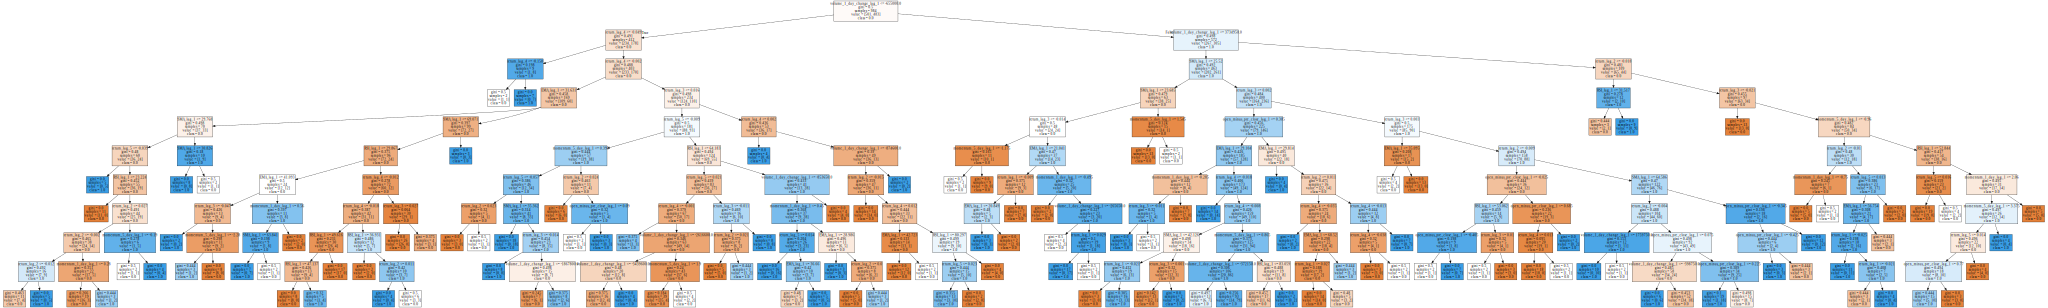

In [37]:
# plot up the decision tree
# DOT data
dot_data = tree.export_graphviz(M_dtc_cv, 
                                out_file=None, 
                                feature_names=M_fn,  
                                class_names=M_cn,
                                filled=True)
# Draw graph
graph = graphviz.Source(dot_data, format="png") 
graph

[[83 40]
 [70 54]]


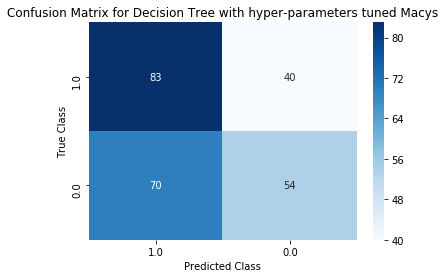

In [38]:
M_dt_cv_cm = plot_confusion_matrix(M_y_test, M_dt_predicted_array_cv, M_class_names, 'Confusion Matrix for Decision Tree with hyper-parameters tuned Macys')

In [39]:
key_metrics(M_y_test, M_dt_predicted_array_cv)
M_dt_cv_spec = (M_dt_cv_cm[1][1]/(M_dt_cv_cm[1][1] + M_dt_cv_cm[1][0]))*100.0
print('Specificity: %.2f%%' % M_dt_cv_spec)

Accuracy: 55.47%
Recall: 55.47%
Precision: 55.85%
F-score: 54.82%
Specificity: 43.55%


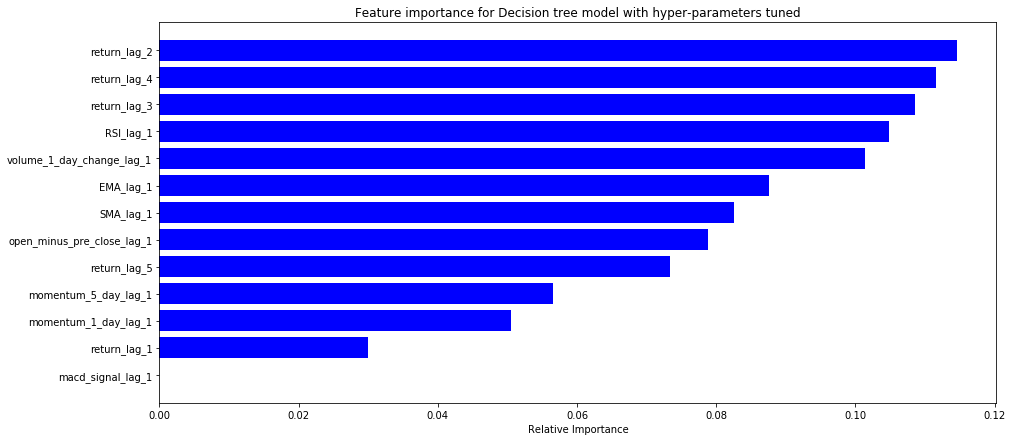

In [40]:
M_importance_dt_cv = M_dtc_cv.feature_importances_
plot_feature_importance(M_y_test, M_dt_predicted_array_cv, M_importance_dt_cv, M_features, 'Feature importance for Decision tree model with hyper-parameters tuned')

### Grid search for decision tree classification for Electronic Arts

In [41]:
print('Grid search for decision tree classification for Electronic Arts')
EA_dtc_cv, EA_dtc_cv_params, EA_dt_predicted_array_cv, EA_dt_predicted_array_cv_train, EA_dt_predicted_proba_cv_train, EA_dt_predicted_proba_cv_test, EA_grid_search_results_dt = run_grid_search(EA_x_train, EA_y_train, EA_x_test, EA_dtc, parameters_dt, scoring, cv)
print('Best hyper-parameters:')
EA_dtc_cv_params

Grid search for decision tree classification for Electronic Arts
Best hyper-parameters:


{'class_weight': None,
 'criterion': 'gini',
 'max_depth': 10,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 8,
 'min_samples_split': 20,
 'min_weight_fraction_leaf': 0.0,
 'presort': False,
 'random_state': 0,
 'splitter': 'best'}

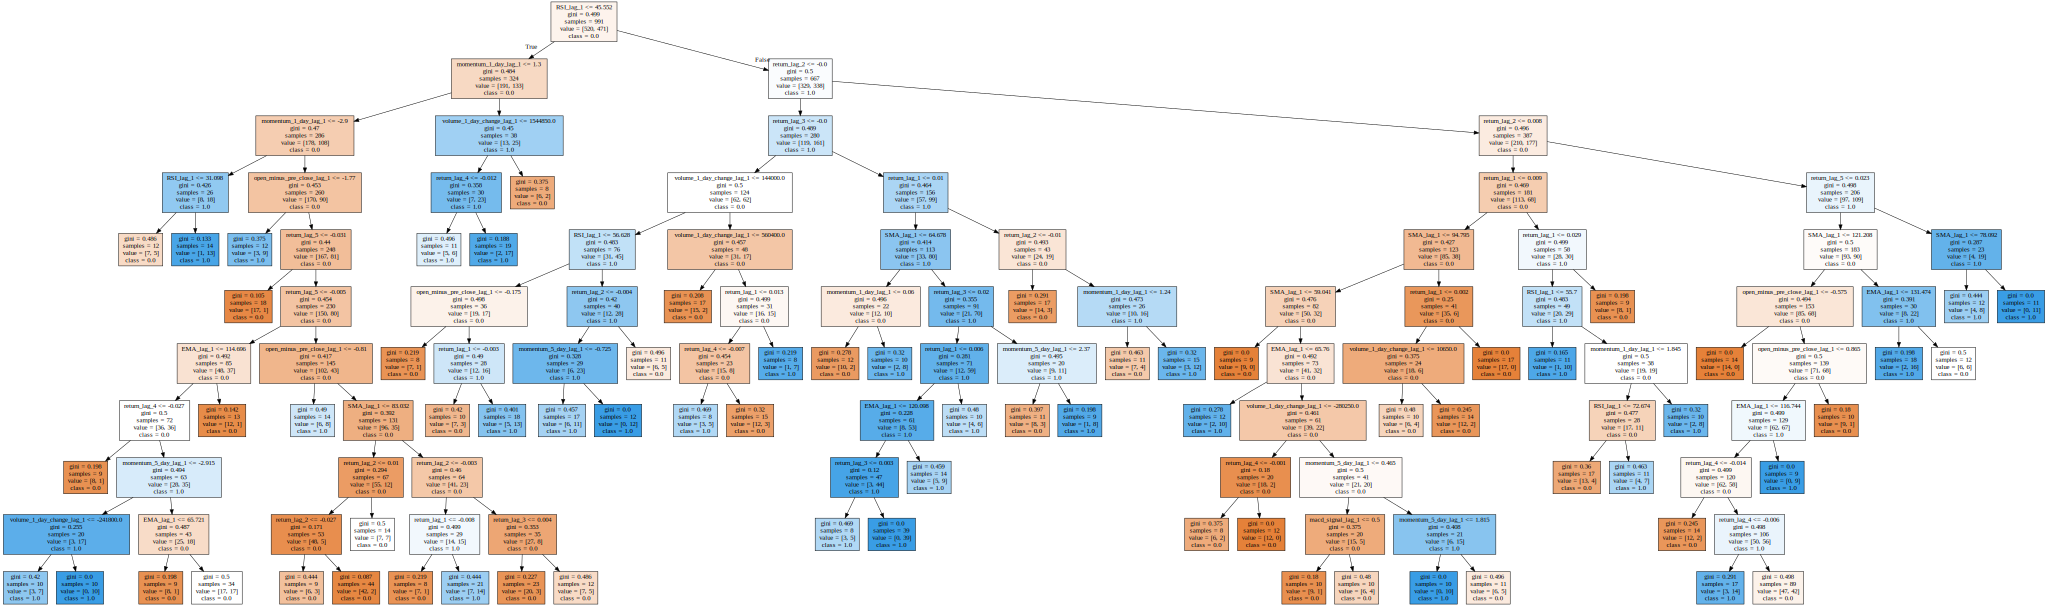

In [42]:
# plot up the decision tree
# DOT data
dot_data = tree.export_graphviz(EA_dtc_cv, 
                                out_file=None, 
                                feature_names=EA_fn,  
                                class_names=EA_cn,
                                filled=True)
# Draw graph
graph = graphviz.Source(dot_data, format="png") 
graph

[[79 47]
 [66 56]]


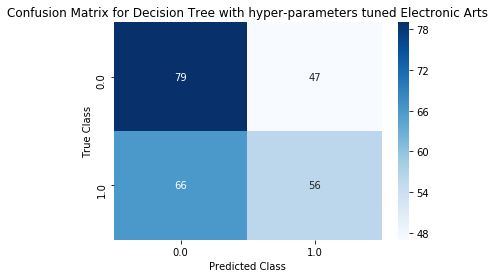

In [43]:
EA_dt_cv_cm = plot_confusion_matrix(EA_y_test, EA_dt_predicted_array_cv, EA_class_names, 'Confusion Matrix for Decision Tree with hyper-parameters tuned Electronic Arts')

In [44]:
key_metrics(EA_y_test, EA_dt_predicted_array_cv)
EA_dt_cv_spec = (EA_dt_cv_cm[1][1]/(EA_dt_cv_cm[1][1] + EA_dt_cv_cm[1][0]))*100.0
print('Specificity: %.2f%%' % EA_dt_cv_spec)

Accuracy: 54.44%
Recall: 54.44%
Precision: 54.43%
F-score: 54.11%
Specificity: 45.90%


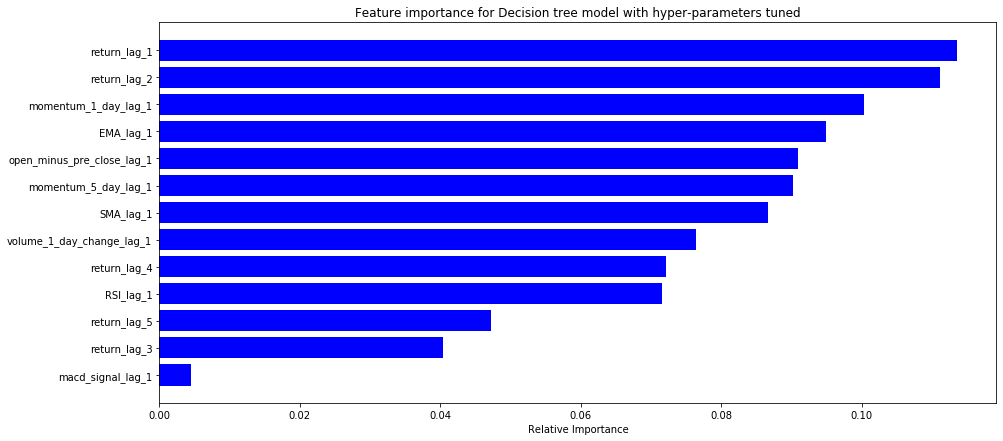

In [45]:
EA_importance_dt_cv = EA_dtc_cv.feature_importances_
plot_feature_importance(EA_y_test, EA_dt_predicted_array_cv, EA_importance_dt_cv, EA_features, 'Feature importance for Decision tree model with hyper-parameters tuned')

# Two models with limited feature overlap

In [46]:
print('features to choose from: ', M_x_train.columns)
# price
price_features = ['return_lag_1', 'return_lag_2', 'return_lag_3', 'open_minus_pre_close_lag_1', 'volume_1_day_change_lag_1']
tscv = TimeSeriesSplit(n_splits=3)
parameters_dt_price = {'criterion':('gini', 'entropy'), 'max_depth':(10, 20), 'min_samples_split':(5, 10, 20), 'min_samples_leaf':(2, 4, 8)}
scoring = 'f1'
cv = tscv
# momentum
mo_features = ['SMA_lag_1', 'momentum_5_day_lag_1', 'momentum_1_day_lag_1', 'EMA_lag_1']
parameters_dt_mo = {'criterion':('gini', 'entropy'), 'max_depth':(10, 20), 'min_samples_split':(5, 10, 20), 'min_samples_leaf':(2, 4, 8)}

features to choose from:  Index(['return_lag_1', 'return_lag_2', 'return_lag_3', 'return_lag_4',
       'return_lag_5', 'macd_signal_lag_1', 'SMA_lag_1',
       'momentum_5_day_lag_1', 'momentum_1_day_lag_1', 'EMA_lag_1',
       'open_minus_pre_close_lag_1', 'volume_1_day_change_lag_1', 'RSI_lag_1'],
      dtype='object')


### Two models with limited feature overlap Macys

In [47]:
print('Two models with limited feature overlap Macys')
# price model:
M_price_x_train = M_x_train[price_features]
M_price_x_test = M_x_test[price_features]
M_dtc_cv_price, M_dtc_cv_params_price, M_dt_predicted_array_cv_price, M_dt_predicted_array_cv_price_train, M_dt_predicted_proba_cv_price_train, M_dt_predicted_proba_cv_price_test, M_grid_search_results_price = run_grid_search(M_price_x_train, M_y_train, M_price_x_test, M_dtc, parameters_dt_price, scoring, cv)
print('Best hyper-parameters:')
M_dtc_cv_params_price

Two models with limited feature overlap Macys
Best hyper-parameters:


{'class_weight': None,
 'criterion': 'gini',
 'max_depth': 10,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 8,
 'min_samples_split': 5,
 'min_weight_fraction_leaf': 0.0,
 'presort': False,
 'random_state': 0,
 'splitter': 'best'}

In [48]:
# momentum model:
M_mo_x_train = M_x_train[mo_features]
M_mo_x_test = M_x_test[mo_features]
M_dtc_cv_mo, M_dtc_cv_params_mo, M_dt_predicted_array_cv_mo, M_dt_predicted_array_cv_mo_train, M_dt_predicted_proba_cv_mo_train, M_dt_predicted_proba_cv_mo_test, M_grid_search_results_mo = run_grid_search(M_mo_x_train, M_y_train, M_mo_x_test, M_dtc, parameters_dt_mo, scoring, cv)
print('Best hyper-parameters:')
M_dtc_cv_params_mo

Best hyper-parameters:


{'class_weight': None,
 'criterion': 'gini',
 'max_depth': 20,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 4,
 'min_samples_split': 20,
 'min_weight_fraction_leaf': 0.0,
 'presort': False,
 'random_state': 0,
 'splitter': 'best'}

[[59 64]
 [67 57]]


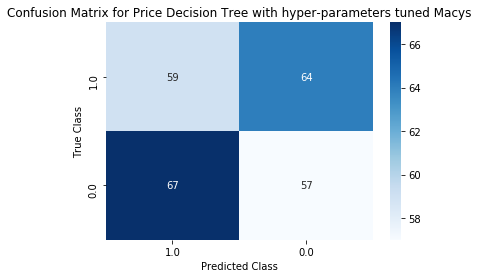

In [49]:
M_dt_cv_price_cm = plot_confusion_matrix(M_y_test, M_dt_predicted_array_cv_price, M_class_names, 'Confusion Matrix for Price Decision Tree with hyper-parameters tuned Macys')

[[92 31]
 [86 38]]


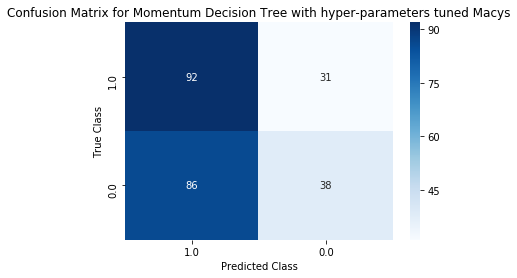

In [50]:
M_dt_cv_mo_cm = plot_confusion_matrix(M_y_test, M_dt_predicted_array_cv_mo, M_class_names, 'Confusion Matrix for Momentum Decision Tree with hyper-parameters tuned Macys')

In [51]:
key_metrics(M_y_test, M_dt_predicted_array_cv_price)
# specificity
M_dt_cv_price_spec = (M_dt_cv_price_cm[1][1]/(M_dt_cv_price_cm[1][1] + M_dt_cv_price_cm[1][0]))*100.0
print('Specificity: %.2f%%' % M_dt_cv_price_spec)

Accuracy: 46.96%
Recall: 46.96%
Precision: 46.97%
F-score: 46.96%
Specificity: 45.97%


In [52]:
key_metrics(M_y_test, M_dt_predicted_array_cv_mo)
# specificity
M_dt_cv_mo_spec = (M_dt_cv_mo_cm[1][1]/(M_dt_cv_mo_cm[1][1] + M_dt_cv_mo_cm[1][0]))*100.0
print('Specificity: %.2f%%' % M_dt_cv_mo_spec)

Accuracy: 52.63%
Recall: 52.63%
Precision: 53.39%
F-score: 50.21%
Specificity: 30.65%


### Two models with limited feature overlap Electronic Arts

In [53]:
print('Two models with limited feature overlap Electronic Arts')
# price model:
EA_price_x_train = EA_x_train[price_features]
EA_price_x_test = EA_x_test[price_features]
EA_dtc_cv_price, EA_dtc_cv_params_price, EA_dt_predicted_array_cv_price, EA_dt_predicted_array_cv_price_train, EA_dt_predicted_proba_cv_price_train, EA_dt_predicted_proba_cv_price_test, EA_grid_search_results_price = run_grid_search(EA_price_x_train, EA_y_train, EA_price_x_test, EA_dtc, parameters_dt_price, scoring, cv)
print('Best hyper-parameters:')
EA_dtc_cv_params_price

Two models with limited feature overlap Electronic Arts
Best hyper-parameters:


{'class_weight': None,
 'criterion': 'entropy',
 'max_depth': 20,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'min_weight_fraction_leaf': 0.0,
 'presort': False,
 'random_state': 0,
 'splitter': 'best'}

In [54]:
# momentum model:
EA_mo_x_train = EA_x_train[mo_features]
EA_mo_x_test = EA_x_test[mo_features]
EA_dtc_cv_mo, EA_dtc_cv_params_mo, EA_dt_predicted_array_cv_mo, EA_dt_predicted_array_cv_mo_train, EA_dt_predicted_proba_cv_mo_train, EA_dt_predicted_proba_cv_mo_test, EA_grid_search_results_mo = run_grid_search(EA_mo_x_train, EA_y_train, EA_mo_x_test, EA_dtc, parameters_dt_mo, scoring, cv)
print('Best hyper-parameters:')
EA_dtc_cv_params_mo

Best hyper-parameters:


{'class_weight': None,
 'criterion': 'gini',
 'max_depth': 20,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 4,
 'min_samples_split': 20,
 'min_weight_fraction_leaf': 0.0,
 'presort': False,
 'random_state': 0,
 'splitter': 'best'}

[[67 59]
 [68 54]]


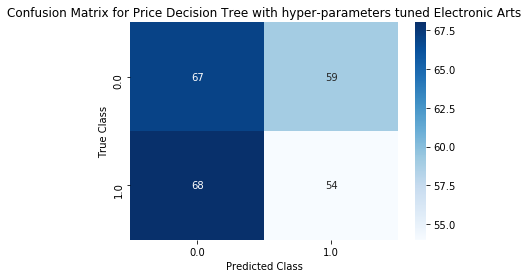

In [55]:
EA_dt_cv_price_cm = plot_confusion_matrix(EA_y_test, EA_dt_predicted_array_cv_price, EA_class_names, 'Confusion Matrix for Price Decision Tree with hyper-parameters tuned Electronic Arts')

[[74 52]
 [68 54]]


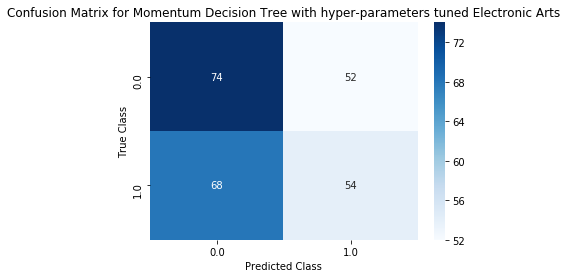

In [56]:
EA_dt_cv_mo_cm = plot_confusion_matrix(EA_y_test, EA_dt_predicted_array_cv_mo, EA_class_names, 'Confusion Matrix for Momentum Decision Tree with hyper-parameters tuned Electronic Arts')

In [57]:
key_metrics(EA_y_test, EA_dt_predicted_array_cv_price)
# specificity
EA_dt_cv_price_spec = (EA_dt_cv_price_cm[1][1]/(EA_dt_cv_price_cm[1][1] + EA_dt_cv_price_cm[1][0]))*100.0
print('Specificity: %.2f%%' % EA_dt_cv_price_spec)

Accuracy: 48.79%
Recall: 48.79%
Precision: 48.72%
F-score: 48.69%
Specificity: 44.26%


In [58]:
key_metrics(EA_y_test, EA_dt_predicted_array_cv_mo)
# specificity
EA_dt_cv_mo_spec = (EA_dt_cv_mo_cm[1][1]/(EA_dt_cv_mo_cm[1][1] + EA_dt_cv_mo_cm[1][0]))*100.0
print('Specificity: %.2f%%' % EA_dt_cv_mo_spec)

Accuracy: 51.61%
Recall: 51.61%
Precision: 51.54%
F-score: 51.36%
Specificity: 44.26%


# Improving Negative returns

In [59]:
print('features to choose from: ', M_x_train.columns)

features to choose from:  Index(['return_lag_1', 'return_lag_2', 'return_lag_3', 'return_lag_4',
       'return_lag_5', 'macd_signal_lag_1', 'SMA_lag_1',
       'momentum_5_day_lag_1', 'momentum_1_day_lag_1', 'EMA_lag_1',
       'open_minus_pre_close_lag_1', 'volume_1_day_change_lag_1', 'RSI_lag_1'],
      dtype='object')


In [60]:
tscv = TimeSeriesSplit(n_splits=3)
parameters_dt_neg = {'min_samples_split':(5, 10, 20), 'min_samples_leaf':(2, 4, 8)}
scoring = 'accuracy'
cv = tscv

### Improving negative returns for Macys

Looking at the gride search decision tree the top features which split the negative returns the best are: 'open_minus_pre_close_lag_1', 'volume_1_day_change_lag_1', 'RSI_lag_1', 'return_lag_1', 'return_lag_2', 'return_lag_5', 'momentum_5_day_lag_1'

In [61]:
print('Improving negative returns for Macys')
M_neg_features = ['open_minus_pre_close_lag_1', 'volume_1_day_change_lag_1', 'RSI_lag_1', 'return_lag_1', 'return_lag_2', 'return_lag_5', 'momentum_5_day_lag_1']
M_neg_x_train = M_x_train[M_neg_features]
M_neg_x_test = M_x_test[M_neg_features]
M_dtc_cv_neg, M_dtc_cv_params_neg, M_dt_predicted_array_cv_neg, M_dt_predicted_array_cv_neg_train, M_dt_predicted_proba_cv_neg_train, M_dt_predicted_proba_cv_neg_test, M_grid_search_results_neg = run_grid_search(M_neg_x_train, M_y_train, M_neg_x_test, M_dtc, parameters_dt_neg, scoring, cv)
print('Best hyper-parameters:')
M_dtc_cv_params_neg

Improving negative returns for Macys
Best hyper-parameters:


{'class_weight': None,
 'criterion': 'gini',
 'max_depth': 10,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'min_weight_fraction_leaf': 0.0,
 'presort': False,
 'random_state': 0,
 'splitter': 'best'}

[[70 53]
 [48 76]]


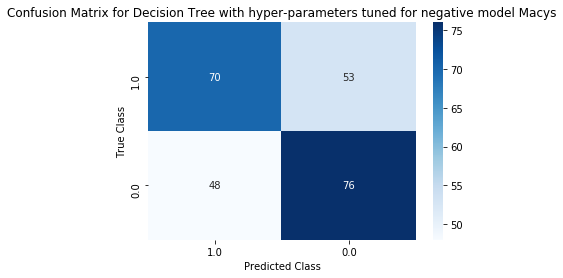

In [62]:
M_dt_cv_neg_cm = plot_confusion_matrix(M_y_test, M_dt_predicted_array_cv_neg, M_class_names, 'Confusion Matrix for Decision Tree with hyper-parameters tuned for negative model Macys')

In [63]:
key_metrics(M_y_test, M_dt_predicted_array_cv_neg)
# specificity
M_dt_cv_neg_spec = (M_dt_cv_neg_cm[1][1]/(M_dt_cv_neg_cm[1][1] + M_dt_cv_neg_cm[1][0]))*100.0
print('Specificity: %.2f%%' % M_dt_cv_neg_spec)

Accuracy: 59.11%
Recall: 59.11%
Precision: 59.12%
F-score: 59.09%
Specificity: 61.29%


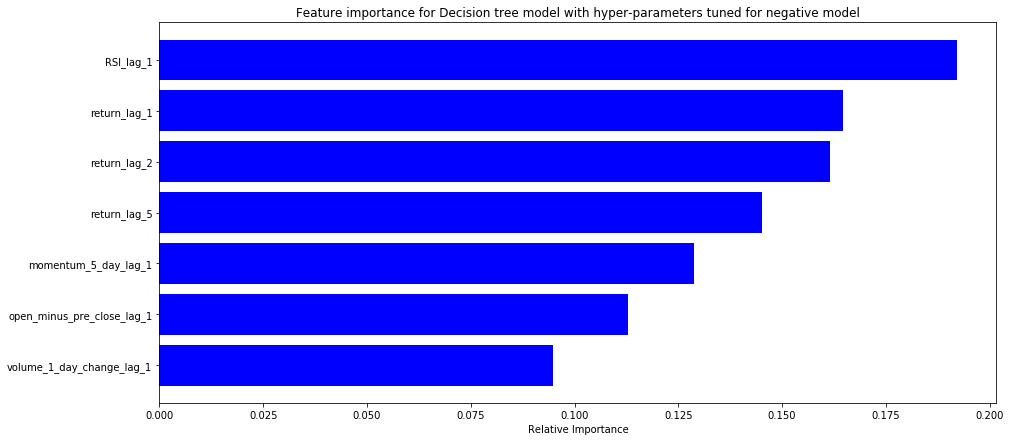

In [64]:
M_neg_features = M_neg_x_train.columns
M_importance_dt_neg = M_dtc_cv_neg.feature_importances_
plot_feature_importance(M_y_test, M_dt_predicted_array_cv_neg, M_importance_dt_neg, M_neg_features, 'Feature importance for Decision tree model with hyper-parameters tuned for negative model')

### Improving negative returns for Electronic Arts

Looking at the gride search decision tree the top features which split the negative returns the best are: 
'return_lag_1', 'RSI_lag_1', 'momentum_5_day_lag_1','return_lag_3', 'EMA_lag_1'

In [65]:
print('Improving negative returns for Electronic Arts')
EA_neg_features = ['return_lag_1','RSI_lag_1', 'momentum_5_day_lag_1','return_lag_3', 'EMA_lag_1']
EA_neg_x_train = EA_x_train[EA_neg_features]
EA_neg_x_test = EA_x_test[EA_neg_features]
EA_dtc_cv_neg, EA_dtc_cv_params_neg, EA_dt_predicted_array_cv_neg, EA_dt_predicted_array_cv_neg_train, EA_dt_predicted_proba_cv_neg_train, EA_dt_predicted_proba_cv_neg_test, EA_grid_search_results_neg = run_grid_search(EA_neg_x_train, EA_y_train, EA_neg_x_test, EA_dtc, parameters_dt_neg, scoring, cv)
print('Best hyper-parameters:')
EA_dtc_cv_params_neg

Improving negative returns for Electronic Arts
Best hyper-parameters:


{'class_weight': None,
 'criterion': 'gini',
 'max_depth': 10,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 8,
 'min_samples_split': 20,
 'min_weight_fraction_leaf': 0.0,
 'presort': False,
 'random_state': 0,
 'splitter': 'best'}

[[68 58]
 [54 68]]


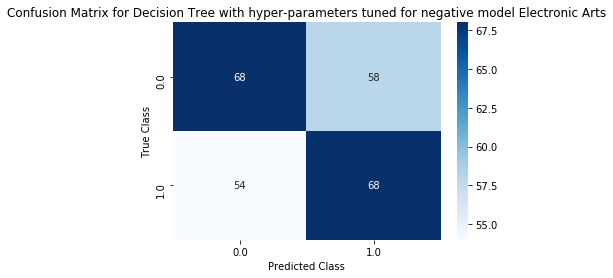

In [66]:
EA_dt_cv_neg_cm = plot_confusion_matrix(EA_y_test, EA_dt_predicted_array_cv_neg, EA_class_names, 'Confusion Matrix for Decision Tree with hyper-parameters tuned for negative model Electronic Arts')

In [67]:
key_metrics(EA_y_test, EA_dt_predicted_array_cv_neg)
# specificity
EA_dt_cv_neg_spec = (EA_dt_cv_neg_cm[1][1]/(EA_dt_cv_neg_cm[1][1] + EA_dt_cv_neg_cm[1][0]))*100.0
print('Specificity: %.2f%%' % EA_dt_cv_neg_spec)

Accuracy: 54.84%
Recall: 54.84%
Precision: 54.87%
F-score: 54.84%
Specificity: 55.74%


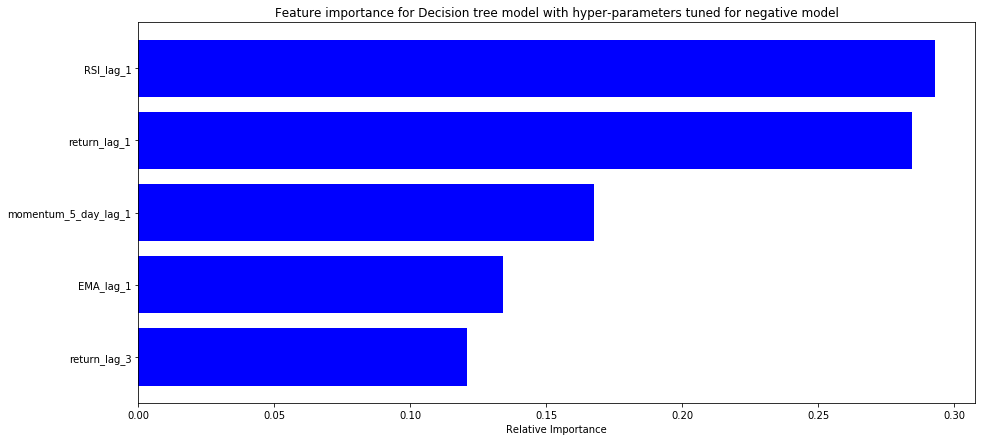

In [68]:
EA_neg_features = EA_neg_x_train.columns
EA_importance_dt_neg = EA_dtc_cv_neg.feature_importances_
plot_feature_importance(EA_y_test, EA_dt_predicted_array_cv_neg, EA_importance_dt_neg, EA_neg_features, 'Feature importance for Decision tree model with hyper-parameters tuned for negative model')

# AdaBoost

In [69]:
# hyper-parameters
n_estimators = 500
learning_rate = 0.2
base_estimator = DecisionTreeClassifier(max_depth=1)

### AdaBoost for Macys

AdaBoost for Macys


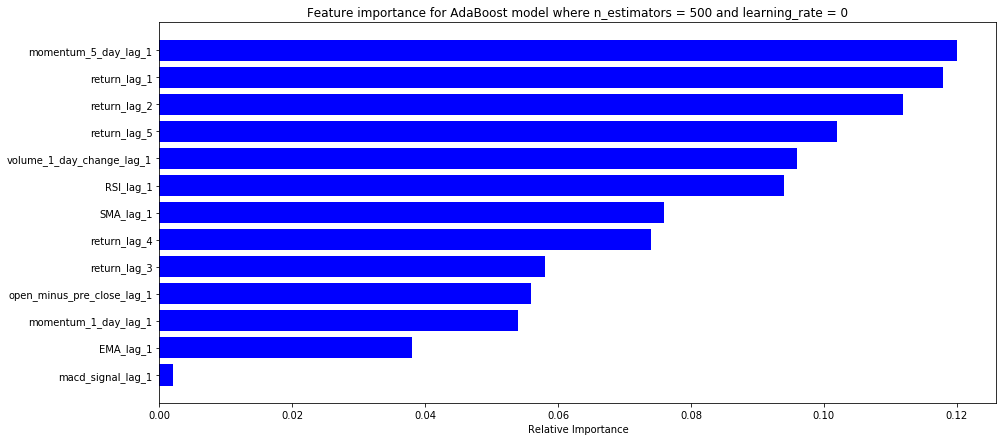

In [70]:
print('AdaBoost for Macys')

M_abc, M_predicted_array_ab, M_predicted_array_ab_train, M_abc_predicted_proba_train, M_abc_predicted_proba_test = run_adaboost(M_x_train, M_y_train, M_x_test, n_estimators, learning_rate, base_estimator)
    
M_importance_ab = M_abc.feature_importances_
plot_feature_importance(M_y_test, M_predicted_array_ab, M_importance_ab, M_features, str('Feature importance for AdaBoost model where n_estimators = %.0f and learning_rate = %.0f' % (n_estimators, learning_rate)))

[[96 27]
 [76 48]]


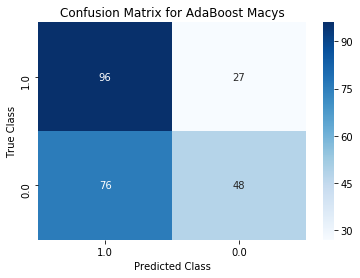

In [71]:
M_ab_cm = plot_confusion_matrix(M_y_test, M_predicted_array_ab, M_class_names, 'Confusion Matrix for AdaBoost Macys')

In [72]:
key_metrics(M_y_test, M_predicted_array_ab)

Accuracy: 58.30%
Recall: 58.30%
Precision: 59.92%
F-score: 56.63%


### AdaBoost for Electronic Arts

AdaBoost for Electronic Arts


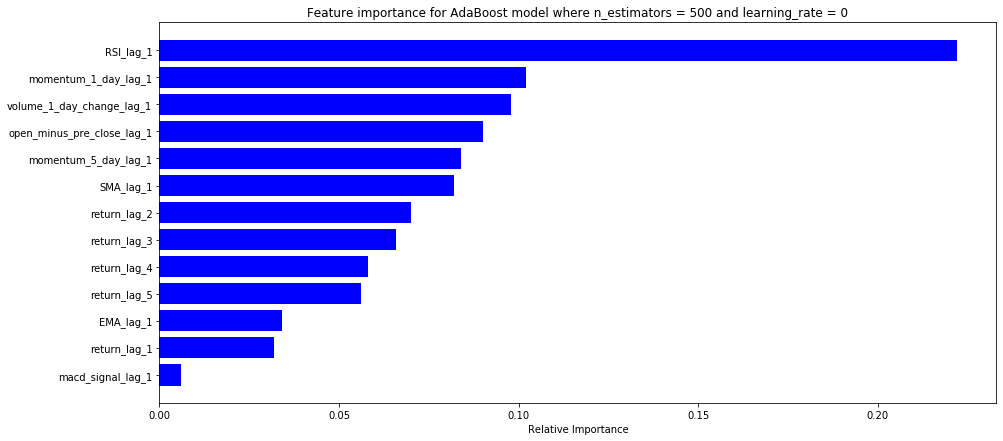

In [73]:
print('AdaBoost for Electronic Arts')

EA_abc, EA_predicted_array_ab, EA_predicted_array_ab_train, EA_abc_predicted_proba_train, EA_abc_predicted_proba_test = run_adaboost(EA_x_train, EA_y_train, EA_x_test, n_estimators, learning_rate, base_estimator)
    
EA_importance_ab = EA_abc.feature_importances_
plot_feature_importance(EA_y_test, EA_predicted_array_ab, EA_importance_ab, EA_features, str('Feature importance for AdaBoost model where n_estimators = %.0f and learning_rate = %.0f' % (n_estimators, learning_rate)))

[[82 44]
 [62 60]]


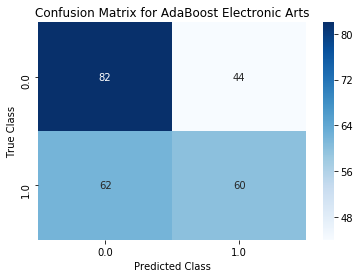

In [74]:
EA_ab_cm = plot_confusion_matrix(EA_y_test, EA_predicted_array_ab, EA_class_names, 'Confusion Matrix for AdaBoost Electronic Arts')

In [75]:
key_metrics(EA_y_test, EA_predicted_array_ab)

Accuracy: 57.26%
Recall: 57.26%
Precision: 57.31%
F-score: 56.98%


# Overfitting proof

### Macys

In [76]:
print('Macys Decision Tree\nThe metrics for the train dataset')
key_metrics(M_y_train, M_dt_predicted_array_train)
print('The metrics for the test dataset')
key_metrics(M_y_test, M_dt_predicted_array)

Macys Decision Tree
The metrics for the train dataset
Accuracy: 84.45%
Recall: 84.45%
Precision: 84.48%
F-score: 84.44%
The metrics for the test dataset
Accuracy: 53.85%
Recall: 53.85%
Precision: 54.36%
F-score: 52.64%


In [77]:
print('Macys Decision Tree hyperparameters tuned\nThe metrics for the train dataset')
key_metrics(M_y_train, M_dt_predicted_array_cv_train)
print('The metrics for the test dataset')
key_metrics(M_y_test, M_dt_predicted_array_cv)

Macys Decision Tree hyperparameters tuned
The metrics for the train dataset
Accuracy: 87.20%
Recall: 87.20%
Precision: 87.47%
F-score: 87.16%
The metrics for the test dataset
Accuracy: 55.47%
Recall: 55.47%
Precision: 55.85%
F-score: 54.82%


In [78]:
print('Macys Decision Tree for negative returns\nThe metrics for the train dataset')
key_metrics(M_y_train, M_dt_predicted_array_cv_neg_train)
print('The metrics for the test dataset')
key_metrics(M_y_test, M_dt_predicted_array_cv_neg)

Macys Decision Tree for negative returns
The metrics for the train dataset
Accuracy: 83.33%
Recall: 83.33%
Precision: 83.33%
F-score: 83.33%
The metrics for the test dataset
Accuracy: 59.11%
Recall: 59.11%
Precision: 59.12%
F-score: 59.09%


In [79]:
print('Macys AdaBoost\nThe metrics for the train dataset')
key_metrics(M_y_train, M_predicted_array_ab_train)
print('The metrics for the test dataset')
key_metrics(M_y_test, M_predicted_array_ab)

Macys AdaBoost
The metrics for the train dataset
Accuracy: 73.68%
Recall: 73.68%
Precision: 73.69%
F-score: 73.67%
The metrics for the test dataset
Accuracy: 58.30%
Recall: 58.30%
Precision: 59.92%
F-score: 56.63%


### Electronic Arts

In [80]:
print('Electronic Arts Decision Tree\nThe metrics for the train dataset')
key_metrics(EA_y_train, EA_dt_predicted_array_train)
print('The metrics for the test dataset')
key_metrics(EA_y_test, EA_dt_predicted_array)

Electronic Arts Decision Tree
The metrics for the train dataset
Accuracy: 81.03%
Recall: 81.03%
Precision: 81.24%
F-score: 81.04%
The metrics for the test dataset
Accuracy: 51.61%
Recall: 51.61%
Precision: 51.69%
F-score: 51.57%


In [81]:
print('Electronic Arts Decision Tree hyperparameters tuned\nThe metrics for the train dataset')
key_metrics(EA_y_train, EA_dt_predicted_array_cv_train)
print('The metrics for the test dataset')
key_metrics(EA_y_test, EA_dt_predicted_array_cv)

Electronic Arts Decision Tree hyperparameters tuned
The metrics for the train dataset
Accuracy: 77.09%
Recall: 77.09%
Precision: 77.50%
F-score: 76.89%
The metrics for the test dataset
Accuracy: 54.44%
Recall: 54.44%
Precision: 54.43%
F-score: 54.11%


In [82]:
print('Electronic Arts Decision Tree for negative returns\nThe metrics for the train dataset')
key_metrics(EA_y_train, EA_dt_predicted_array_cv_neg_train)
print('The metrics for the test dataset')
key_metrics(EA_y_test, EA_dt_predicted_array_cv_neg)

Electronic Arts Decision Tree for negative returns
The metrics for the train dataset
Accuracy: 74.97%
Recall: 74.97%
Precision: 74.97%
F-score: 74.97%
The metrics for the test dataset
Accuracy: 54.84%
Recall: 54.84%
Precision: 54.87%
F-score: 54.84%


In [83]:
print('Electronic Arts AdaBoost\nThe metrics for the train dataset')
key_metrics(EA_y_train, EA_predicted_array_ab_train)
print('The metrics for the test dataset')
key_metrics(EA_y_test, EA_predicted_array_ab)

Electronic Arts AdaBoost
The metrics for the train dataset
Accuracy: 73.46%
Recall: 73.46%
Precision: 73.98%
F-score: 73.14%
The metrics for the test dataset
Accuracy: 57.26%
Recall: 57.26%
Precision: 57.31%
F-score: 56.98%


# Decision Boundaries

### Decision boundaries for Macys

Decision boundaries for top four Decision tree after hyper-parameter tuning features Macys


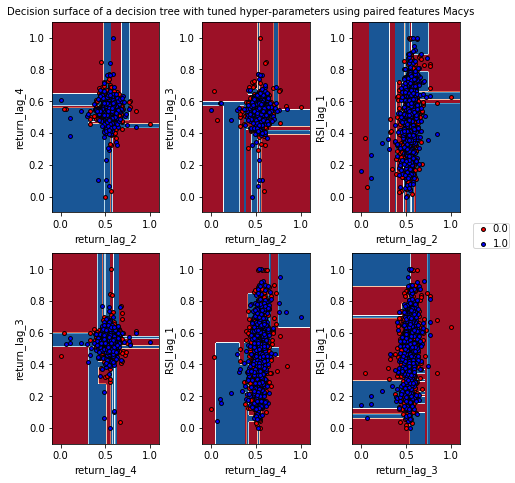

In [84]:
print('Decision boundaries for top four Decision tree after hyper-parameter tuning features Macys')
# top four features from the model
M_indices_dt_cv = np.argsort(M_importance_dt_cv)
M_indices_dt_cv_correct_order = M_indices_dt_cv[::-1]
M_feature_1 = M_features[M_indices_dt_cv_correct_order][0]
M_feature_2 = M_features[M_indices_dt_cv_correct_order][1]
M_feature_3 = M_features[M_indices_dt_cv_correct_order][2]
M_feature_4 = M_features[M_indices_dt_cv_correct_order][3]

plot_title = 'Decision surface of a decision tree with tuned hyper-parameters using paired features Macys'

# re-train the model with the best parameters
M_dtc_cv.fit(M_x_train, M_y_train)

# currently commented out as taking too long to run on personal laptop
decision_boundary_four_features(M_x_train, M_y_train, M_feature_1, M_feature_2, M_feature_3, M_feature_4, M_dtc_cv, plot_title, M_cn)

Decision boundaries for top four Decision tree features optimised for negative returns Macys


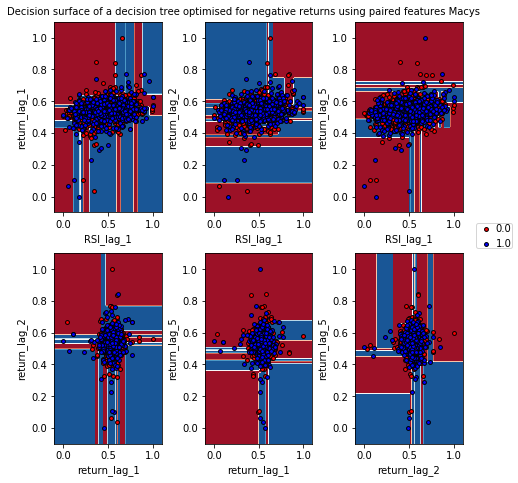

In [85]:
print('Decision boundaries for top four Decision tree features optimised for negative returns Macys')
# # top four features from the model
M_indices_dt_neg = np.argsort(M_importance_dt_neg)
M_indices_dt_neg_correct_order = M_indices_dt_neg[::-1]
M_feature_1_dt_neg = M_neg_features[M_indices_dt_neg_correct_order][0]
M_feature_2_dt_neg = M_neg_features[M_indices_dt_neg_correct_order][1]
M_feature_3_dt_neg = M_neg_features[M_indices_dt_neg_correct_order][2]
M_feature_4_dt_neg = M_neg_features[M_indices_dt_neg_correct_order][3]

plot_title = 'Decision surface of a decision tree optimised for negative returns using paired features Macys'

decision_boundary_four_features(M_neg_x_train, M_y_train, M_feature_1_dt_neg, M_feature_2_dt_neg, M_feature_3_dt_neg, M_feature_4_dt_neg, M_dtc_cv_neg, plot_title, M_cn)

Decision boundaries for top four AdaBoost features Macys


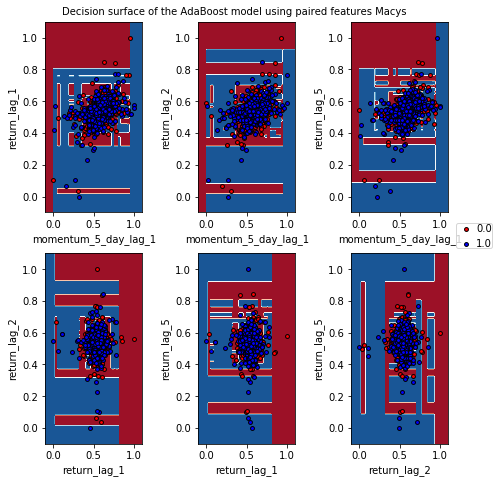

In [86]:
print('Decision boundaries for top four AdaBoost features Macys')
# top four features from the model
M_indices_ab = np.argsort(M_importance_ab)
M_indices_ab_correct_order = M_indices_ab[::-1]
M_feature_1 = M_features[M_indices_ab_correct_order][0]
M_feature_2 = M_features[M_indices_ab_correct_order][1]
M_feature_3 = M_features[M_indices_ab_correct_order][2]
M_feature_4 = M_features[M_indices_ab_correct_order][3]

plot_title = 'Decision surface of the AdaBoost model using paired features Macys'

# currently commented out as taking too long to run on personal laptop
decision_boundary_four_features(M_x_train, M_y_train, M_feature_1, M_feature_2, M_feature_3, M_feature_4, M_abc, plot_title, M_cn)

### Decision boundaries for Electronic Arts

Decision boundaries for top four Decision tree after hyper-parameter tuning features Electronic Arts


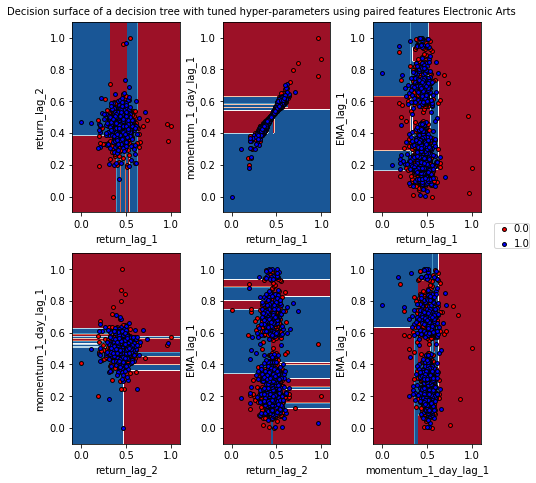

In [87]:
print('Decision boundaries for top four Decision tree after hyper-parameter tuning features Electronic Arts')
# top four features from the model
EA_indices_dt_cv = np.argsort(EA_importance_dt_cv)
EA_indices_dt_cv_correct_order = EA_indices_dt_cv[::-1]
EA_feature_1 = EA_features[EA_indices_dt_cv_correct_order][0]
EA_feature_2 = EA_features[EA_indices_dt_cv_correct_order][1]
EA_feature_3 = EA_features[EA_indices_dt_cv_correct_order][2]
EA_feature_4 = EA_features[EA_indices_dt_cv_correct_order][3]

plot_title = 'Decision surface of a decision tree with tuned hyper-parameters using paired features Electronic Arts'

# re-train the model with the best parameters
EA_dtc_cv.fit(EA_x_train, EA_y_train)

# currently commented out as taking too long to run on personal laptop
decision_boundary_four_features(EA_x_train, EA_y_train, EA_feature_1, EA_feature_2, EA_feature_3, EA_feature_4, EA_dtc_cv, plot_title, EA_cn)

Decision boundaries for top four Decision tree features optimised for negative returns Electronic Arts


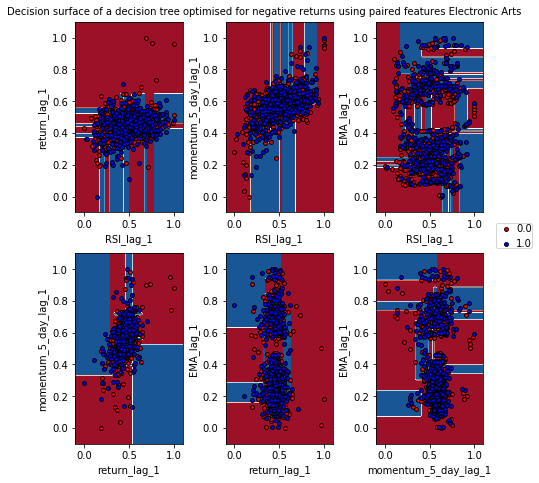

In [88]:
print('Decision boundaries for top four Decision tree features optimised for negative returns Electronic Arts')
# # top four features from the model
EA_indices_dt_neg = np.argsort(EA_importance_dt_neg)
EA_indices_dt_neg_correct_order = EA_indices_dt_neg[::-1]
EA_feature_1_dt_neg = EA_neg_features[EA_indices_dt_neg_correct_order][0]
EA_feature_2_dt_neg = EA_neg_features[EA_indices_dt_neg_correct_order][1]
EA_feature_3_dt_neg = EA_neg_features[EA_indices_dt_neg_correct_order][2]
EA_feature_4_dt_neg = EA_neg_features[EA_indices_dt_neg_correct_order][3]

plot_title = 'Decision surface of a decision tree optimised for negative returns using paired features Electronic Arts'

decision_boundary_four_features(EA_neg_x_train, EA_y_train, EA_feature_1_dt_neg, EA_feature_2_dt_neg, EA_feature_3_dt_neg, EA_feature_4_dt_neg, EA_dtc_cv_neg, plot_title, EA_cn)

Decision boundaries for top four AdaBoost features Electronic Arts


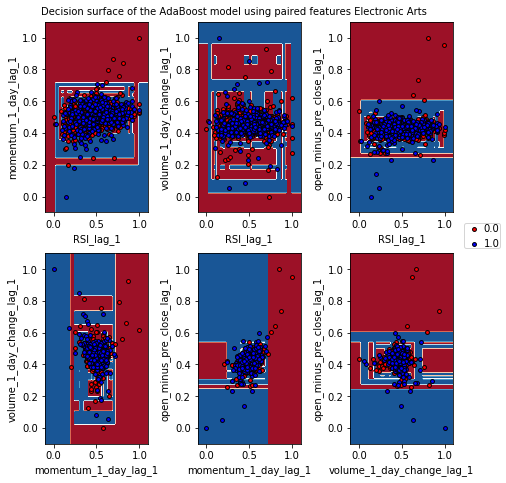

In [89]:
print('Decision boundaries for top four AdaBoost features Electronic Arts')
# top four features from the model
EA_indices_ab = np.argsort(EA_importance_ab)
EA_indices_ab_correct_order = EA_indices_ab[::-1]
EA_feature_1 = EA_features[EA_indices_ab_correct_order][0]
EA_feature_2 = EA_features[EA_indices_ab_correct_order][1]
EA_feature_3 = EA_features[EA_indices_ab_correct_order][2]
EA_feature_4 = EA_features[EA_indices_ab_correct_order][3]

plot_title = 'Decision surface of the AdaBoost model using paired features Electronic Arts'

# currently commented out as taking too long to run on personal laptop
decision_boundary_four_features(EA_x_train, EA_y_train, EA_feature_1, EA_feature_2, EA_feature_3, EA_feature_4, EA_abc, plot_title, EA_cn)

# Transtion Probability - Scatter plots showing the probability and true value of the data points for the DT post grid search and for the negative returns model

### Transition Probabilities Macys - Training and Test Data Set

Decision tree optimised for negative returns transition probabilities Macys


/Users/helendavidge/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


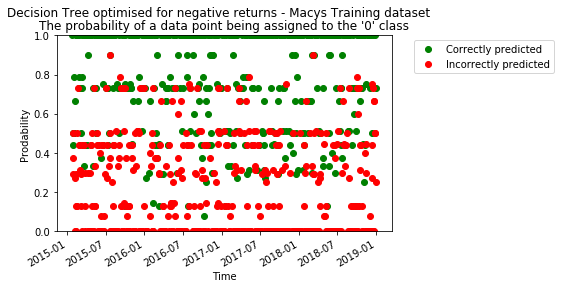

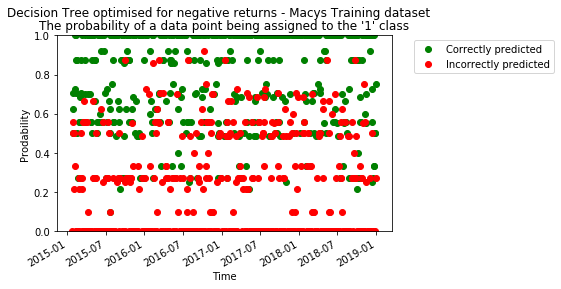

In [90]:
print('Decision tree optimised for negative returns transition probabilities Macys')
plotting_transition_probabilty(M_dt_predicted_proba_cv_neg_train, M_y_train, M_date_time_train, 'Decision Tree optimised for negative returns - Macys Training dataset')

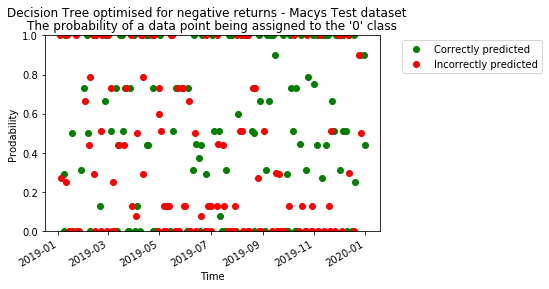

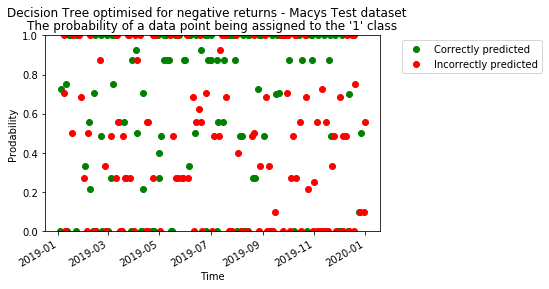

In [91]:
plotting_transition_probabilty(M_dt_predicted_proba_cv_neg_test, M_y_test, M_date_time_test, 'Decision Tree optimised for negative returns - Macys Test dataset')

Decision tree after grid search transition probabilities Macys


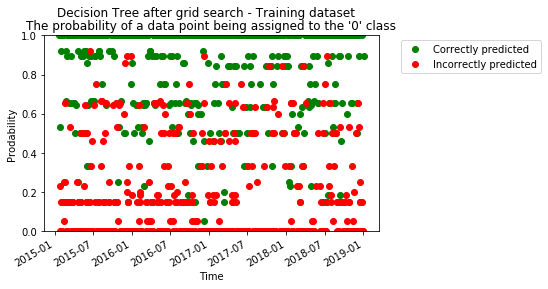

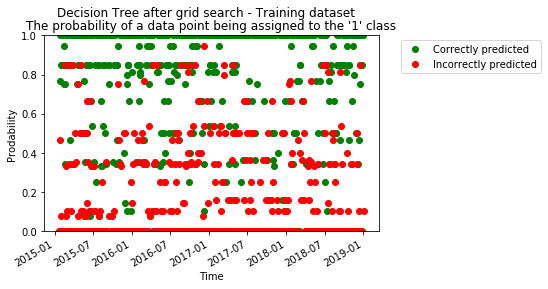

In [92]:
print('Decision tree after grid search transition probabilities Macys')
plotting_transition_probabilty(M_dt_predicted_proba_cv_train, M_y_train, M_date_time_train, 'Decision Tree after grid search - Training dataset')

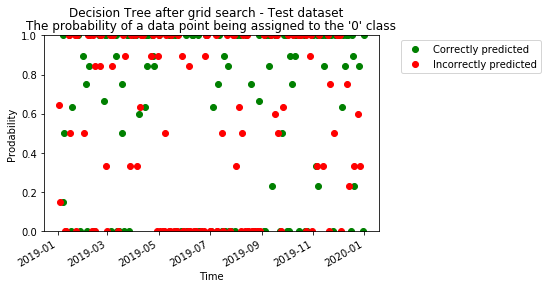

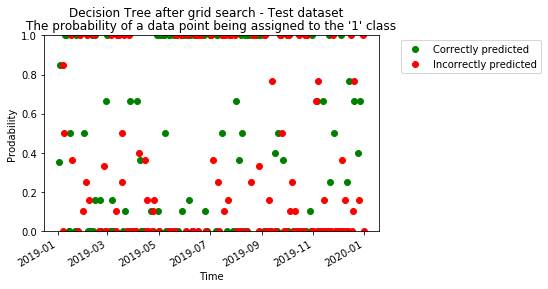

In [93]:
plotting_transition_probabilty(M_dt_predicted_proba_cv_test, M_y_test, M_date_time_test, 'Decision Tree after grid search - Test dataset')

### Transition Probabilities Electronic Arts - Training and Test Data Set

Decision tree optimised for negative returns transition probabilities Electronic Arts


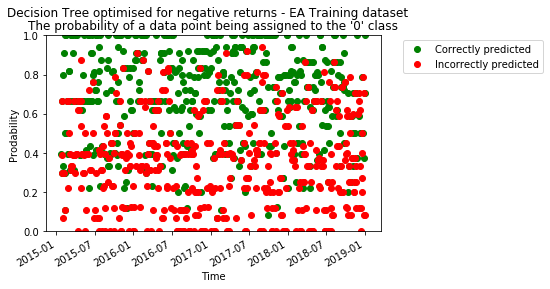

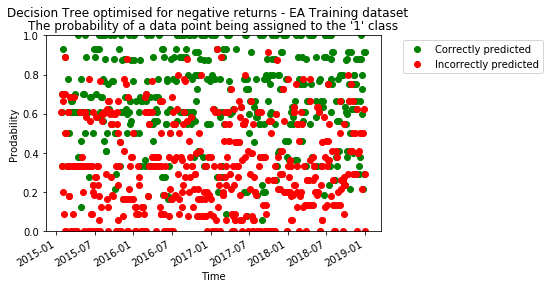

In [94]:
print('Decision tree optimised for negative returns transition probabilities Electronic Arts')
plotting_transition_probabilty(EA_dt_predicted_proba_cv_neg_train, EA_y_train, EA_date_time_train, 'Decision Tree optimised for negative returns - EA Training dataset')

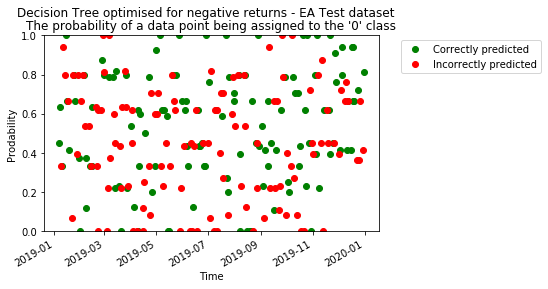

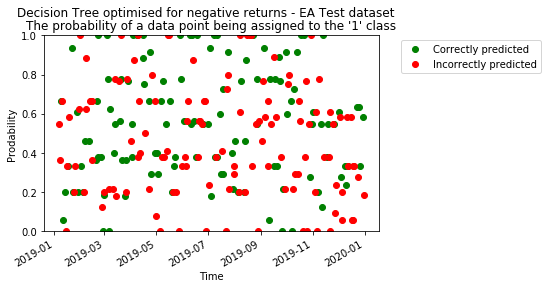

In [95]:
plotting_transition_probabilty(EA_dt_predicted_proba_cv_neg_test, EA_y_test, EA_date_time_test, 'Decision Tree optimised for negative returns - EA Test dataset')

Decision tree after grid search transition probabilities Electronic Arts


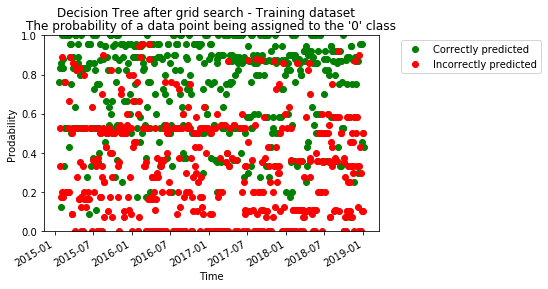

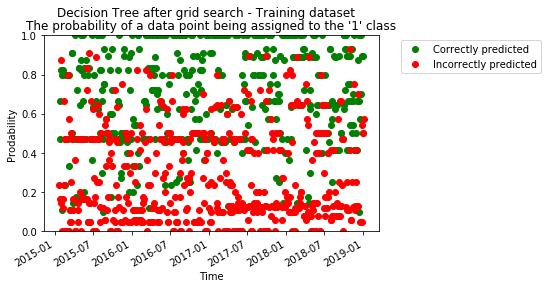

In [96]:
print('Decision tree after grid search transition probabilities Electronic Arts')
plotting_transition_probabilty(EA_dt_predicted_proba_cv_train, EA_y_train, EA_date_time_train, 'Decision Tree after grid search - Training dataset')

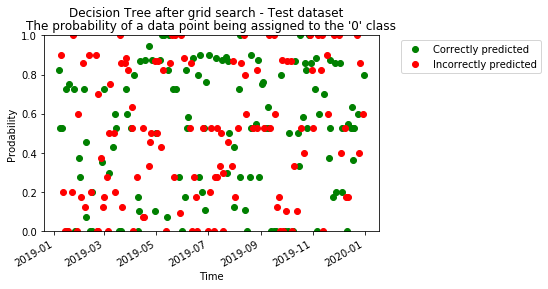

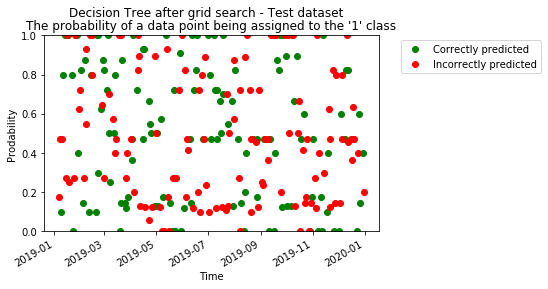

In [97]:
plotting_transition_probabilty(EA_dt_predicted_proba_cv_test, EA_y_test, EA_date_time_test, 'Decision Tree after grid search - Test dataset')